Dataset:
http://h2o-public-test-data.s3.amazonaws.com/smalldata/iris/iris_wheader.csv

Problem:
    
For this task we want to see how a simple analysis using group_by can provide insight into categorizing the different Iris Species. Please complete the following:

   1. Import the Iris dataset, path is already provided.
   1. Run a groupby on Species type, generating the mean of C1-C4 for each group.
   1. Build a K-Means model with 3 centeroids.
   1. Compare the simple aggregated data with the K-Means model, just meaningful explanation or code to showing difference would be acceptable.

In [2]:
import h2o
h2o.init()
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
sns.set()


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_101"; Java(TM) SE Runtime Environment (build 1.8.0_101-b13); Java HotSpot(TM) 64-Bit Server VM (build 25.101-b13, mixed mode)
  Starting server from /Users/mihirzgr8/anaconda/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/bc/btz_3q257nb_qgtzwwt7tj1m0000gn/T/tmpf9r7z9dj
  JVM stdout: /var/folders/bc/btz_3q257nb_qgtzwwt7tj1m0000gn/T/tmpf9r7z9dj/h2o_mihirzgr8_started_from_python.out
  JVM stderr: /var/folders/bc/btz_3q257nb_qgtzwwt7tj1m0000gn/T/tmpf9r7z9dj/h2o_mihirzgr8_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.2
H2O cluster version age:,1 month and 17 days
H2O cluster name:,H2O_from_python_mihirzgr8_xp25hc
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,0
H2O cluster allowed cores:,0
H2O cluster status:,"accepting new members, healthy"


In [3]:
#Import the dataset in an h2o dataframe
iris = "http://h2o-public-test-data.s3.amazonaws.com/smalldata/iris/iris_wheader.csv"
iris_df = h2o.import_file(path=iris)
iris_df.shape

Parse progress: |█████████████████████████████████████████████████████████| 100%


(150, 5)

In [4]:
iris_df.describe()

Rows:150
Cols:5




,sepal_len,sepal_wid,petal_len,petal_wid,class
type,real,real,real,real,enum
mins,4.3,2.0,1.0,0.1,
mean,5.843333333333333,3.053999999999999,3.758666666666667,1.1986666666666665,
maxs,7.9,4.4,6.9,2.5,
sigma,0.8280661279778637,0.43359431136217375,1.764420419952262,0.7631607417008414,
zeros,0,0,0,0,
missing,0,0,0,0,0
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa


In [5]:
iris_df.columns


['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']

In [6]:
cols_1=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']

In [7]:
cols_2=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid']

In [8]:
iris_df[cols_1].group_by(by='class').mean(cols_2, na ="ignore").get_frame()

class,mean_sepal_len,mean_sepal_wid,mean_petal_len,mean_petal_wid
Iris-setosa,5.006,3.418,1.464,0.244
Iris-versicolor,5.936,2.77,4.26,1.326
Iris-virginica,6.588,2.974,5.552,2.026


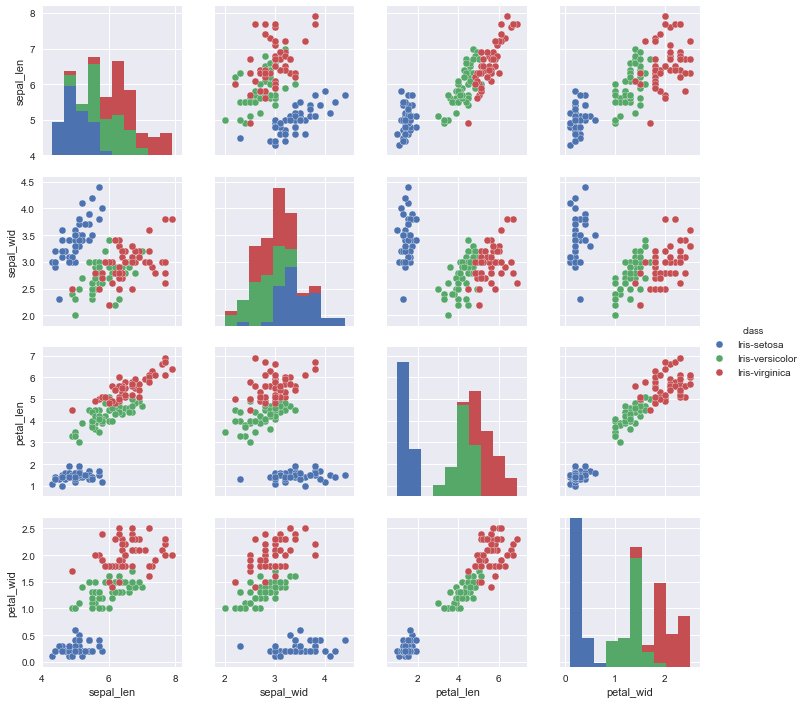

In [9]:
sns.set_context("notebook")
sns.pairplot(iris_df.as_data_frame(True), vars=["sepal_len", "sepal_wid", "petal_len", "petal_wid"], hue="class");

In [10]:
from h2o.estimators.kmeans import H2OKMeansEstimator

In [11]:
# convert response column to a factor
iris_df['class'] = iris_df['class'].asfactor()

# set the predictor names
predictors = iris_df.columns[:-1]

# split into train and validation sets
train, valid = iris_df.split_frame(ratios = [.8], seed = 1234)

# estimator to train the model, parameters as under: 

# k =the upper limit of classes to consider/ number of clusters
# k-estimate= True inorder to estimate number of clusters
# standardize= False since the scales for each feature are very close

iris_kmeans = H2OKMeansEstimator(k = 3, estimate_k = True, standardize = False, seed = 1234)
iris_kmeans.train(x = predictors, training_frame = train, validation_frame=valid)




kmeans Model Build progress: |████████████████████████████████████████████| 100%


In [12]:
#Calculate important results obtained from the k-means model

import math as math
import pandas as pd

def diagnostics_from_clusteringmodel(model):
    total_within_sumofsquares = model.tot_withinss()
    number_of_clusters = len(model.centers())
    number_of_dimensions = len(model.centers()[0])
    number_of_rows = sum(model.size())
    
    aic = total_within_sumofsquares + 2 * number_of_dimensions * number_of_clusters
    bic = total_within_sumofsquares + math.log(number_of_rows) * number_of_dimensions * number_of_clusters
    
    return {'Clusters':number_of_clusters,
            'Total Within SS':total_within_sumofsquares, 
            'AIC':aic, 
            'BIC':bic}



In [13]:
diagnostics_from_clusteringmodel(iris_kmeans)

{'AIC': 87.09516069071749,
 'BIC': 120.8413729551865,
 'Clusters': 3,
 'Total Within SS': 63.09516069071749}

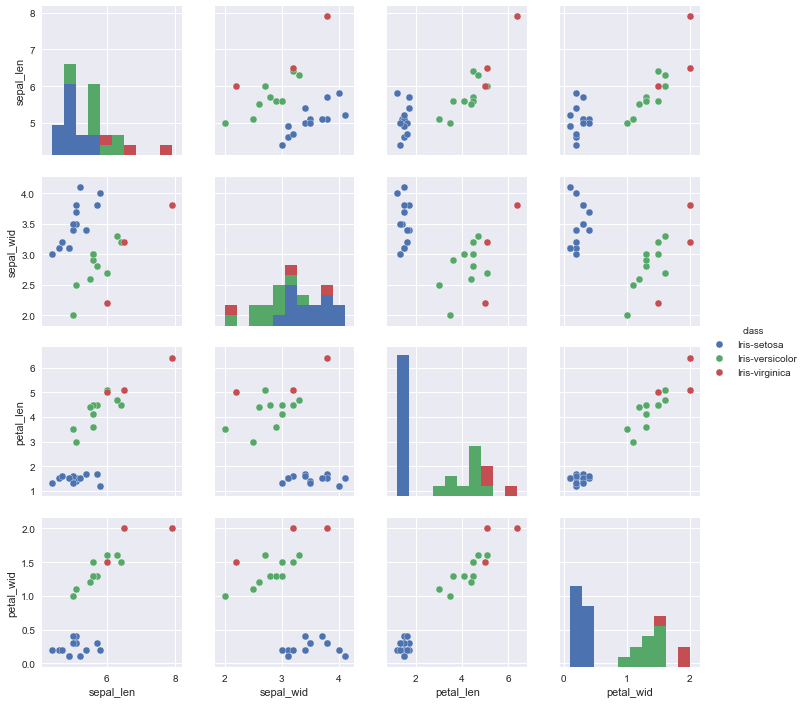

In [14]:
#Pairplot of the validation frame
sns.pairplot(valid.as_data_frame(True),vars=["sepal_len", "sepal_wid", "petal_len", "petal_wid"], hue="class");

## Comparision of results 

Group by and the calculation of mean based on each column provides us with mean of each feature based on the species type. 

K-means operates by grouping points close to each centroid, provides in depth results of which points are closely related and to the mean and which are further away

Key Difference: 
    
    For Group By we must specify the columns we need to group by explicitly by providing column names, which may not be an efficient technique. 
    
    For K-means, we can input any number of features and the algorithm finds the number of clusters, using the "k" parameter we can state the number of centroids. 
    
    "K-estimate" can be set to true to find the number of centroids automatically. 